In [38]:
import cudf
from sklearn.preprocessing import LabelEncoder

data = cudf.read_csv('agaricus-lepiota.data')

dataset_pd = data.to_pandas()

# Apply LabelEncoder to each column
label_encoder = LabelEncoder()
for column in dataset_pd.columns:
    dataset_pd[column] = label_encoder.fit_transform(dataset_pd[column])

data = cudf.DataFrame.from_pandas(dataset_pd)

data = data.astype('float32')
data.values

array([[1., 5., 2., ..., 2., 3., 5.],
       [0., 5., 2., ..., 3., 2., 1.],
       [0., 0., 2., ..., 3., 2., 3.],
       ...,
       [0., 2., 2., ..., 0., 1., 2.],
       [1., 3., 3., ..., 7., 4., 2.],
       [0., 5., 2., ..., 4., 1., 2.]], dtype=float32)

In [39]:
import cuml
from cuml.cluster import KMeans
from cuml.metrics.cluster import silhouette_score as metric_score

clusters = range(2, 10)
seeds = range(20)
results = []

clusters_calulated = 0

for seed in seeds:
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, random_state=seed).fit(data.to_cupy())
        score = metric_score(data.to_numpy(), kmeans.labels_)
        results.append([cluster, seed, score])

        clusters_calulated += 1
        print("Clusters calculated", clusters_calulated, end="\r")
        
    print(end="\r")

cudf.DataFrame(results, columns=['Clusters', 'Seed', 'Silhouette Score'])
results

KeyboardInterrupt: 

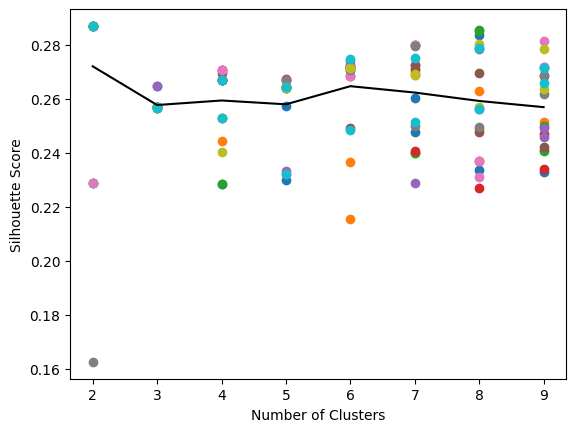

In [3]:
import matplotlib.pyplot as plt

colormap = plt.get_cmap('tab10', len(seeds))

for seed in seeds:
    seed_results = [result for result in results if result[1] == seed]
    plt.scatter([result[0] for result in seed_results], [result[2] for result in seed_results], color=colormap(seed), label=f'Seed {seed}')

average_scores = []
for cluster in clusters:
    average_score = sum([result[2] for result in results if result[0] == cluster]) / len(seeds)
    average_scores.append(average_score)

plt.plot(clusters, average_scores, color='black', label='Average Score')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
%matplotlib notebook

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4, random_state=0).fit(data.to_cupy().get())

pca = PCA(n_components=3)
data_pca = pca.fit_transform(dataset_pd)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=kmeans.labels_, cmap='viridis', 
           marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


<IPython.core.display.Javascript object>